In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
#from tqdm.notebook import tqdm
import tensorflow.keras as keras
import tensorflow as tf


In [2]:
np.random.seed(2021)
tf.random.set_seed(2022)

In [3]:
sig = 10.
rho = 28.
beta = 8./3

def Lorenz_model(v, sig=sig, rho=rho, beta=beta):
    x, y, z = v[...,0], v[...,1], v[...,2]
    
    dxdt = sig*(y-x)
    dydt = rho*x - y - x*z
    dzdt = x*y - beta*z
    
    return np.stack((dxdt, dydt, dzdt),axis=-1)

In [4]:
def RK4 (model, v, dt):
    k1 = model(v)
    k2 = model(v + dt*k1/2.)
    k3 = model(v + dt*k2/2.)
    k4 = model(v + dt*k3)
    return v + (1./6.)*dt*(k1 + 2*k2 + 2*k3 + k4)

In [5]:
v0 = np.array([1.509, -1.531, 25.46]) + 0.1*np.random.randn(3)
K = 50000
dt = 0.01


In [6]:
def simulate(forward, K, v0, N=0, burnin=500):
    """
    simulate an ensemble of forward models over K time steps.
    :forward: forward model
    :K: number of time steps to generate
    :N: enseømble size (if N=0, no ensemble)
    :v0: initial state (shape: (3,N)), if N=0. (shape: (3))
    :burnin: number of initial time step to discard (spinup period)
    """
    V = np.zeros((K+burnin,N,3)) if N>0 else np.zeros((K+burnin,3)) 
    V[0,...] = v0
    for i in range(1,K+burnin):
        V[i] =forward(V[i-1])
    return V[burnin:]

In [7]:
forward = lambda v: RK4(Lorenz_model, v,dt)

V = simulate(forward, K, v0)

In [8]:
V.shape

(50000, 3)

In [53]:
def phase_plot(V,cmap='summer', fig=None, ax=None):
    """
    Plot the trajectory V in dense plot in the phase space
    """
    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
    ax[1,0].hist2d(V[:,0],V[:,1], bins=(120,120), norm=mpl.colors.LogNorm(), cmap=cmap);
    ax[0,0].hist2d(V[:,0],V[:,2], bins=(120,120), norm=mpl.colors.LogNorm(), cmap=cmap);
    ax[0,1].hist2d(V[:,1],V[:,2], bins=(120,120), norm=mpl.colors.LogNorm(), cmap=cmap);
    ax[1,1].axis('off');
    return fig, ax 

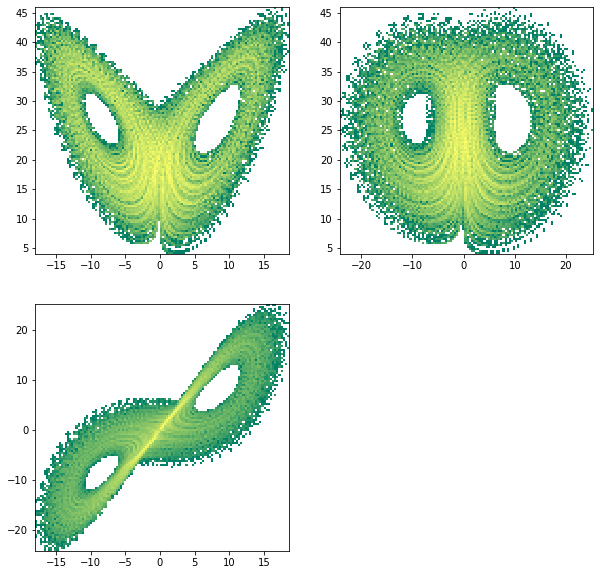

In [56]:
fig, ax = phase_plot(V)

In [11]:
# Training set/Val
Ktrain=10000
Kval = 5000
Ktest = 2000
Ntest = 500

Xtrain = V[0:Ktrain]
ytrain = V[1:Ktrain+1]

Xval = V[Ktrain:Ktrain+Kval]
yval = V[Ktrain+1:Ktrain+Kval+1]

Xval.shape

(5000, 3)

In [12]:
# Test set (ensemble)
v0test = np.array([1.509, -1.531, 25.46])[np.newaxis,:] + 0.1*np.random.randn(Ntest,3)
Vtest = simulate(forward, Ktest, v0test, N=Ntest)
v0test.shape


(500, 3)

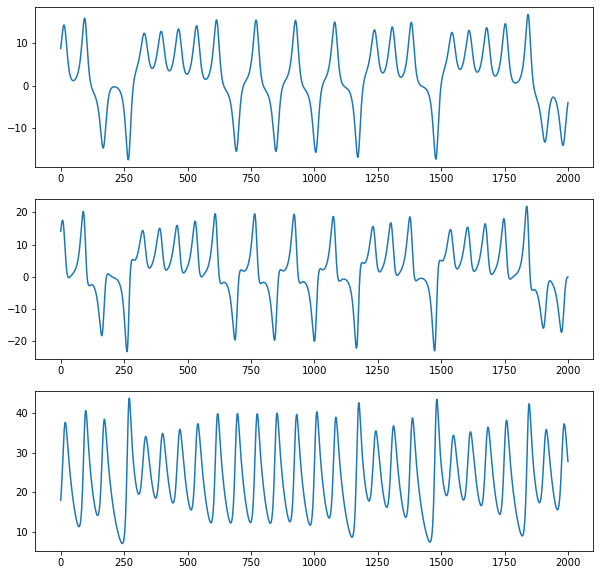

In [13]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(Vtest[:,0,0])
ax[1].plot(Vtest[:,0,1])
ax[2].plot(Vtest[:,0,2])


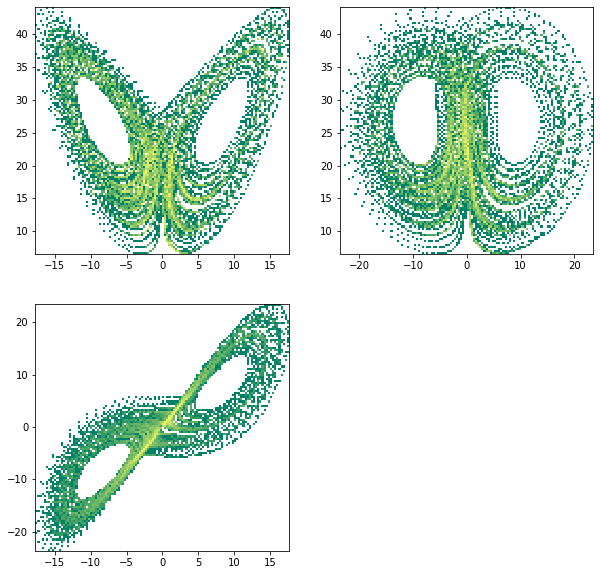

In [59]:
fig, ax = phase_plot(Xtrain)

In [15]:
reg = LinearRegression().fit(Xtrain, ytrain)


In [16]:
ylin = reg.predict(Xval)

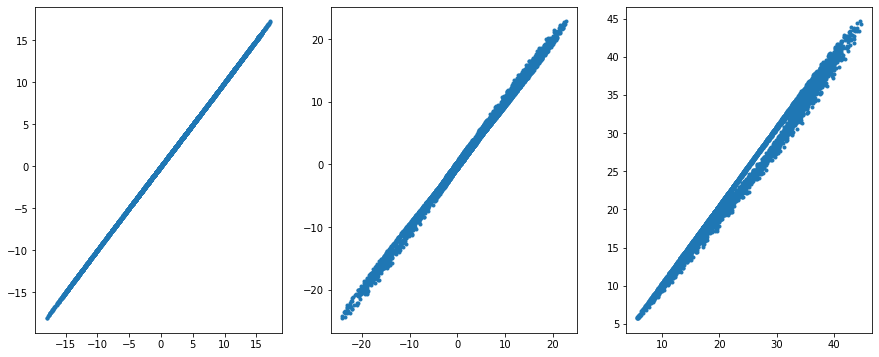

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))
ax[0].plot(yval[:,0],ylin[:,0],'.')
ax[1].plot(yval[:,1],ylin[:,1],'.')
ax[2].plot(yval[:,2],ylin[:,2],'.')

In [18]:
Vtestlin = simulate(reg.predict, Ktest, Vtest[0], N=Ntest,burnin=0)


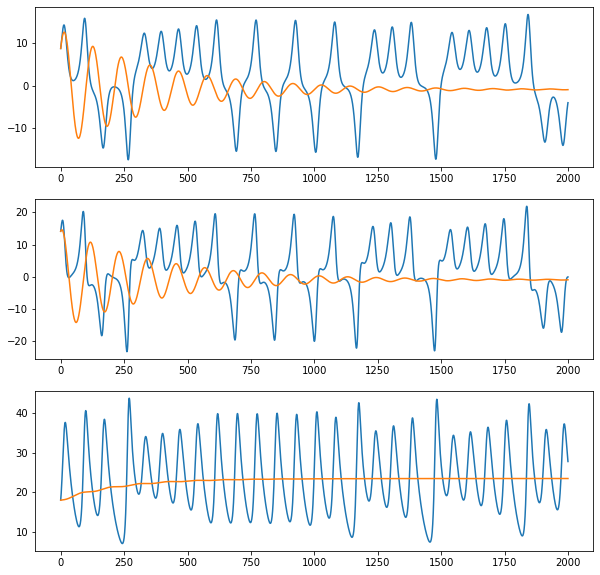

In [19]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(Vtest[:,0,0])
ax[1].plot(Vtest[:,0,1])
ax[2].plot(Vtest[:,0,2])
ax[0].plot(Vtestlin[:,0,0])
ax[1].plot(Vtestlin[:,0,1])
ax[2].plot(Vtestlin[:,0,2])

In [20]:
mean_ = np.mean(Xtrain,axis=0,keepdims=True)
std_= np.std(Xtrain,axis=0, keepdims=True)


norm = lambda x: (x-mean_)/std_
denorm = lambda x: x*std_ + mean_


In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
nn_model = keras.Sequential(
    [
        layers.Dense(50, activation="relu", name="layer1", input_shape=(3,)),
        layers.Dense(20, activation="relu", name="layer2"),
        layers.Dense(3, name="output", activation="linear"),
    ])

In [23]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 50)                200       
_________________________________________________________________
layer2 (Dense)               (None, 20)                1020      
_________________________________________________________________
output (Dense)               (None, 3)                 63        
Total params: 1,283
Trainable params: 1,283
Non-trainable params: 0
_________________________________________________________________


In [24]:
nn_model.compile(optimizer='Adam', loss='mse')

In [25]:
history = nn_model.fit(norm(Xtrain),ytrain, validation_data=(norm(Xval),yval),epochs=100, batch_size=64)

Epoch 1/100
157/157 [==============================] - 1s 3ms/step - loss: 232.8759 - val_loss: 68.9448
Epoch 2/100
157/157 [==============================] - 0s 684us/step - loss: 33.6191 - val_loss: 9.4256
Epoch 3/100
157/157 [==============================] - 0s 678us/step - loss: 7.6196 - val_loss: 3.6743
Epoch 4/100
157/157 [==============================] - 0s 691us/step - loss: 2.7990 - val_loss: 1.4029
Epoch 5/100
157/157 [==============================] - 0s 676us/step - loss: 1.0353 - val_loss: 0.6476
Epoch 6/100
157/157 [==============================] - 0s 683us/step - loss: 0.5181 - val_loss: 0.3873
Epoch 7/100
157/157 [==============================] - 0s 690us/step - loss: 0.3090 - val_loss: 0.2200
Epoch 8/100
157/157 [==============================] - 0s 689us/step - loss: 0.1859 - val_loss: 0.1456
Epoch 9/100
157/157 [==============================] - 0s 679us/step - loss: 0.1230 - val_loss: 0.1015
Epoch 10/100
157/157 [==============================] - 0s 671us/step -

Epoch 80/100
157/157 [==============================] - 0s 652us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 81/100
157/157 [==============================] - 0s 658us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 82/100
157/157 [==============================] - 0s 680us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 83/100
157/157 [==============================] - 0s 700us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 84/100
157/157 [==============================] - 0s 654us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 85/100
157/157 [==============================] - 0s 654us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 86/100
157/157 [==============================] - 0s 667us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 87/100
157/157 [==============================] - 0s 671us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 88/100
157/157 [==============================] - 0s 665us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 89/100
157/157 [==============================] - 0s 683us

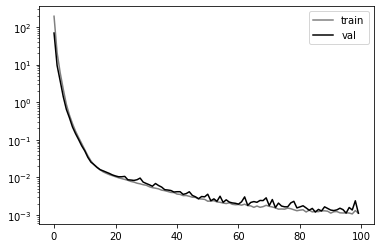

In [26]:
fig, ax = plt.subplots()
ax.semilogy(history.history['loss'],color='gray',label='train')
ax.semilogy(history.history['val_loss'],color='black',label='val')
ax.legend()

In [27]:
ynn = nn_model.predict(norm(Xval))

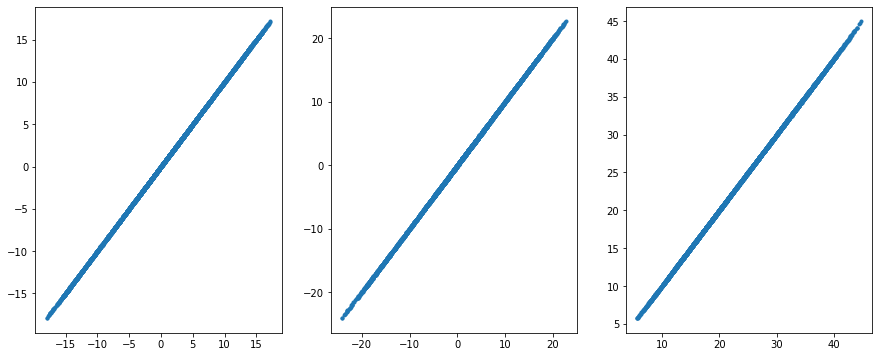

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))
ax[0].plot(yval[:,0],ynn[:,0],'.')
ax[1].plot(yval[:,1],ynn[:,1],'.')
ax[2].plot(yval[:,2],ynn[:,2],'.')

In [29]:
forward_nn = lambda v: nn_model(norm(v), training=False)

#model(np.zeros((1, 1, 1)), training=False)

In [30]:
Vtestnn = simulate(forward_nn, Ktest, Vtest[0], N=Ntest,burnin=0)
ttest = dt*np.arange(Ktest)

In [37]:
def plot_3rows(x,y,ax,**kwfigs):
    for i in range(len(ax)):
        ax[i].plot(x,y[:,i],**kwfigs)

Text(0, 0.5, 'z')

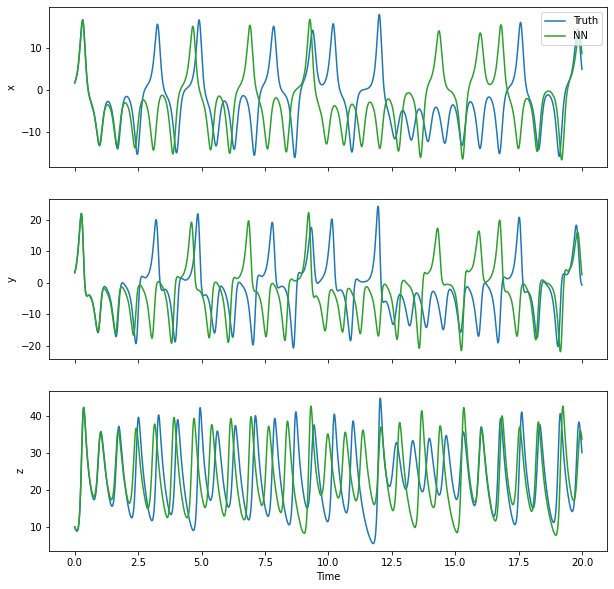

In [44]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10),sharex=True)
plot_3rows(ttest,Vtest[:,1],ax,color='C0',label='Truth')
plot_3rows(ttest,Vtestnn[:,1],ax,color='C2',label='NN')
ax[0].legend()
ax[2].set_xlabel('Time')
ax[0].set_ylabel('x')
ax[1].set_ylabel('y')
ax[2].set_ylabel('z')

In [32]:
def rmse (xref, xest, axis=(1,),norm=True):
    rmse_ret = np.sqrt(np.mean(np.square(xref-xest),axis=axis))
    if norm:
        rmse_ret /= 2*np.std(xref,axis=axis)
    return rmse_ret
#rmse_nn = Vtestnn-Vr

Text(0, 0.5, 'RMSE(z)')

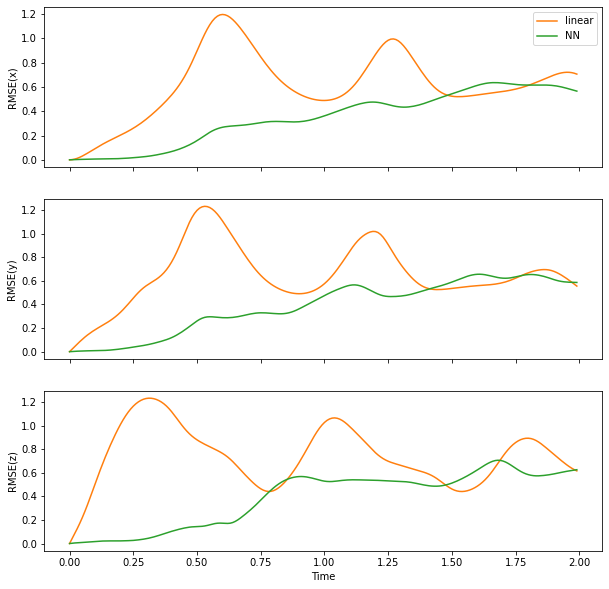

In [49]:
rmse_nn = rmse(Vtest, Vtestnn)
rmse_lin = rmse(Vtest, Vtestlin)
fig, ax = plt.subplots(nrows=3,figsize=(10,10), sharex=True)
plot_3rows(ttest[:200],rmse_lin[:200],ax,color='C1',label='linear')
plot_3rows(ttest[:200],rmse_nn[:200],ax, color='C2',label='NN')
ax[0].legend()
ax[2].set_xlabel('Time')
ax[0].set_ylabel('RMSE(x)')
ax[1].set_ylabel('RMSE(y)')
ax[2].set_ylabel('RMSE(z)')

In [34]:
Vtestnnlong = simulate(forward_nn, K, Vtest[0,:1], burnin=0, N=1).squeeze()


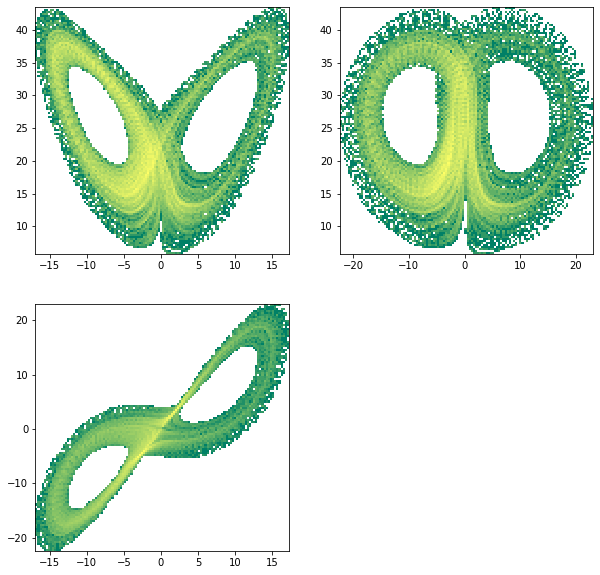

In [35]:
fig, ax = phase_plot(Vtestnnlong)

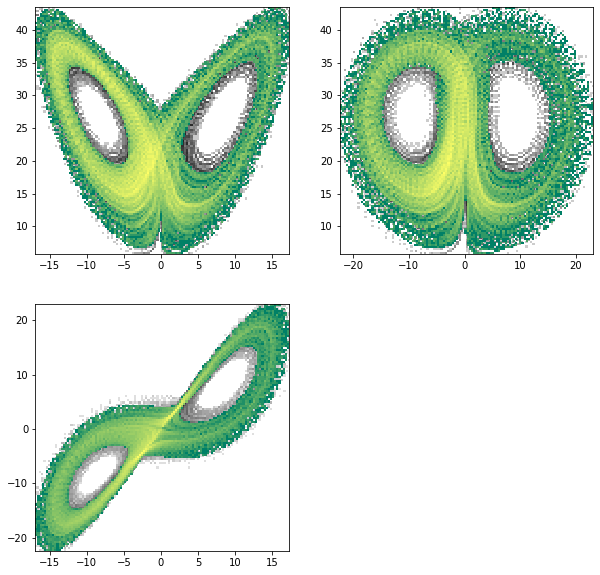

In [58]:
fig, ax = phase_plot(V,cmap='binary')
fig, ax = phase_plot(Vtestnnlong, fig=fig, ax=ax)